## Imports and loads 

In [1]:
import os, sys
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import r2_score
from sklearn import linear_model
from scipy.stats import linregress
from scipy.stats import spearmanr
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi, stft
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import LeaveOneOut
import pickle
from time import time
from  scipy.spatial.distance import squareform
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pickle

In [2]:
!pip install mne==0.19
import mne
!pip install git+https://github.com/UN-GCPDS/python-gcpds.utils.git
from gcpds.utils import loaddb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UN-GCPDS/python-gcpds.utils.git to /tmp/pip-req-build-u8b32p10
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-u8b32p10
  Resolved https://github.com/UN-GCPDS/python-gcpds.utils.git to commit 200d9c2a9f444ba136bbeeeacbaeca11103723d7
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-utils: filename=gcpds_utils-0.1a7-py3-none-any.whl size=15748 sha256=c39c0f529abc715a94fa4599f70daa1d1eeb62ba2e748eada792b2e653335742
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v51xrot/wheels/62/0d/24/3443ac4aafce0b07b66530691bd2e5c5b0ff283897d14f5faa
Successfully built gcpds-utils


ImportError: ignored

In [ ]:
from mne.io.pick import _picks_to_idx
from mne.viz.topomap import _check_outlines, _draw_outlines
from mne.viz import plot_topomap

In [ ]:
FILEID = "1Em1PGP6Ybpgu3Fx0HJznYELIr7obFufV"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O grafos_suxchaxfre.zip && rm -rf /tmp/cookies.txt
!dir
!unzip grafos_suxchaxfre.zip

## Networks definitions

In [ ]:
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)
        
class SMRfeat(BaseEstimator, TransformerMixin):
  def __init__(self):
    self
      
  
  def scalerlist(self,Xfull):
     self.scaler = len(Xfull)*[None]
     for i in range(len(Xfull)):
        self.scaler[i] = StandardScaler()
        Xfull[i] = self.scaler[i].fit_transform(Xfull[i])
     return Xfull


  def fit(self,Xepochs,*_):
      
      Xfull = [Xepochs[:,:,i] for i in range(Xepochs.shape[2])]


      
      self.scalerlist(Xfull)
      return 

  def transform(self,Xepochs,*_):   
      
          
      
      Xfull = [Xepochs[:,:,i] for i in range(Xepochs.shape[2])]

      
      for i in range(len(Xfull)):
         
         Xfull[i] = self.scaler[i].fit_transform(Xfull[i])
      return Xfull

  def fit_transform(self,Xepochs,*_):
      self.fit(Xepochs)
      return self.transform(Xepochs)   
class MCSMRDNN(BaseEstimator, TransformerMixin):
  def __init__(self,epochs=200,batch_size=32,learning_rate=1e-3,optimizer='Adam',
                l1_param=1e-3,l2_param=1e-3,validation_split=0.2,verbose=0,fs=512,scalex=1,scaley=1,droprate=0.2,Mc_iter=100,alpha_dropout=True,plot_hst = False):
        self.epochs = epochs
        self.scalex = scalex
        self.scaley = scaley
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l2_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.fs=fs
        self.droprate = droprate
        self.Mc_iter = Mc_iter
        self.alpha_dropout = alpha_dropout
        self.plot_hst = plot_hst
  
  def fit(self,X,y,*_):

    #entrenar predictor SMRDNN
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer
    
    tf.keras.backend.clear_session()
    seed = 100
    np.random.seed(seed)
    tf.random.set_seed(seed)
    Q1f = 1.5
    Qff = 0.5
    l1 = self.l1_param
    l2 = self.l2_param
    act1 = 'tanh'
    actf = 'tanh'
    inputs = len(X)*[None]
    hiddens = len(X)*[None]
    drop_1 = len(X)*[None]
    winitializer = tf.keras.initializers.GlorotNormal(seed=seed)
    binitializer = "zeros"
    #h1
    for i in range(len(X)):
        inputs[i] = tf.keras.layers.Input(shape=(X[i].shape[1]), name='in_'+str(i))
        hiddens[i] = tf.keras.layers.Dense(int(X[i].shape[1]*Q1f),activation=act1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),kernel_initializer=winitializer,bias_initializer=binitializer,name='h1_'+str(i))(inputs[i])
        if self.alpha_dropout:
            drop_1[i] = tf.keras.layers.AlphaDropout(self.droprate,seed=seed)(hiddens[i])
        else:
            drop_1[i] = tf.keras.layers.Dropout(self.droprate)(hiddens[i])
    #concat
    concat = tf.keras.layers.concatenate(drop_1,name='concat')
    #concat = tf.keras.layers.concatenate([h1c3psd,h1c4psd],name='concat')
    Qh = np.sum([X[i].shape[1]*Q1f for i in range(len(X))])
    
    hfi = tf.keras.layers.Dense(Qh*Qff,activation=actf,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                              kernel_initializer=winitializer,
                              bias_initializer=binitializer,name='hfi')(concat)
    if self.alpha_dropout:
        drop_2 = tf.keras.layers.AlphaDropout(rate=self.droprate)(hfi)
    else:
        drop_2 = tf.keras.layers.Dropout(rate=self.droprate)(hfi)
    #cla
    output_c = tf.keras.layers.Dense(1,activation="linear",kernel_initializer=winitializer, bias_initializer=binitializer,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),name='outc')(drop_2) 
    #input_full = [ic3_tuz,ic4_tuz,ic3_tbz,ic4_tbz,ic3_psdz,ic4_psdz]
    self.model_fun = tf.keras.Model(inputs=inputs,outputs=[output_c])

    self.model_fun.compile(loss=tf.keras.losses.mae,#self.custom_loss(),
              optimizer=opt) #f1, precision, recall, crossentropy

    self.history = self.model_fun.fit(x=X, y=y,verbose=self.verbose,
                        epochs=self.epochs,batch_size=self.batch_size,validation_split=self.validation_split)
    if self.plot_hst:
        self.plot_history_acc_w()
  def predict(self, X, *_):
    return np.stack([self.model_fun(X,training=True) for sample in range(self.Mc_iter)])#self.model_fun.predict(X)

  def fit_predict(self,X,y,*_):
      self.fit(X,y)
      return  self.predict(X)
  def get_model(self):
      return self.model_fun
  def plot_history_acc_w(self):
      hpd = pd.DataFrame(self.history.history)
      #hpd[['loss','val_loss']].plot()
      hpd.plot()
      plt.show()
      return


In [ ]:
class SMRDNN(BaseEstimator, TransformerMixin):
  def __init__(self,epochs=200,batch_size=32,learning_rate=1e-3,optimizer='Adam',
                l1_param=1e-3,l2_param=1e-3,validation_split=0.2,verbose=0,fs=512,scalex=1,scaley=1):
        self.epochs = epochs
        self.scalex = scalex
        self.scaley = scaley
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l2_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.fs=fs
  
  def fit(self,X,y,*_):

    #entrenar predictor SMRDNN
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer
    
    tf.keras.backend.clear_session()
    seed = 100
    np.random.seed(seed)
    tf.random.set_seed(seed)

    Q1f = 1.5
    Qff = 0.5
    l1 = self.l1_param
    l2 = self.l2_param
    act1 = 'tanh'
    actf = 'tanh'
    inputs = len(X)*[None]
    hiddens = len(X)*[None]
    winitializer = tf.keras.initializers.GlorotNormal(seed=seed)
    binitializer = "zeros"
    #h1
    for i in range(len(X)):
        inputs[i] = tf.keras.layers.Input(shape=(X[i].shape[1]), name='in_'+str(i))
        hiddens[i] = tf.keras.layers.Dense(int(X[i].shape[1]*Q1f),activation=act1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),kernel_initializer=winitializer,bias_initializer=binitializer,name='h1_'+str(i))(inputs[i])

    #concat
    concat = tf.keras.layers.concatenate(hiddens,name='concat')
    #concat = tf.keras.layers.concatenate([h1c3psd,h1c4psd],name='concat')
    Qh = np.sum([X[i].shape[1]*Q1f for i in range(len(X))])
    
    hfi = tf.keras.layers.Dense(Qh*Qff,activation=actf,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                              kernel_initializer=winitializer,
                              bias_initializer=binitializer,name='hfi')(concat)

    #cla
    output_c = tf.keras.layers.Dense(1,activation="linear",kernel_initializer=winitializer, bias_initializer=binitializer,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),name='outc')(hfi) 
    #input_full = [ic3_tuz,ic4_tuz,ic3_tbz,ic4_tbz,ic3_psdz,ic4_psdz]
    self.model_fun = tf.keras.Model(inputs=inputs,outputs=[output_c])

    self.model_fun.compile(loss=tf.keras.losses.mae,#self.custom_loss(),
              optimizer=opt) #f1, precision, recall, crossentropy

    self.history = self.model_fun.fit(x=X, y=y,verbose=self.verbose,
                        epochs=self.epochs,batch_size=self.batch_size,validation_split=self.validation_split)
    self.plot_history_acc_w()
  def predict(self, X, *_):
    return  self.model_fun.predict(X)

  def fit_predict(self,X,y,*_):
      self.fit(X,y)
      return  self.predict(X)
      
  def get_model(self):
      return self.model_fun

  def plot_history_acc_w(self):
      hpd = pd.DataFrame(self.history.history)
      #hpd[['loss','val_loss']].plot()
      hpd.plot()
      plt.show()
      return

## Functions definitions

In [ ]:
def get_weigths(model,bands):
    W = []
    for i in range(bands):
        w = np.sum(abs(mdl.get_layer('h1_'+str(i)).get_weights()[0]),axis=1)
        w = w-min(w)
        w/= max(w)
        W.append(w)
    return W

In [ ]:
def create_tensor_giga(graf,ind):
    xtensor = []
    for i in ind:
      if i>= 29 and i<34:
        subjs= graf[i-2,:,:]
      elif i>=34:
        subjs= graf[i-3,:,:]
      else:
        subjs= graf[i-1,:,:]

      try:
        xtensor+=[subjs]
      except:
        print('s'+str(i+1))

    xtensor= np.asarray(xtensor)
    print(xtensor.shape)
    return xtensor

In [ ]:
def plot_topomap_cx(rho,fs, channels_names,montage,Ch,thr=0.5,size=(10,10),mode="topo",weigths=True,cmaps="jet",colormap=True,save=False,name=""):
    layout = mne.channels.read_layout('EEG1005')
    info = mne.create_info(layout.names, sfreq=fs, ch_types="eeg",montage=montage)
    pos = np.array([(p[0] + p[2] / 2., p[1] + p[3] / 2.) for p in layout.pos])

    # pick channels
    picks = _picks_to_idx(info,channels_names)
    pos = pos[picks]
    # adjust positions
    pos, outlines = _check_outlines(pos, 'head')
    pos_x = pos[:,0]
    pos_y = pos[:,1]
    names = np.array(layout.names)[picks]
    rho=((rho-rho.min())/(rho.max()-rho.min()))
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=np.min(rho), vmax=np.max(rho))
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

    if weigths:
        rhotopo = squareform(rho).sum(axis=1)
    else:
        rhotopo = rho
    rhotopo = rhotopo-rhotopo.min()
    rhotopo /= rhotopo.max()
    
    f = plt.figure(figsize=size)
    ax = plt.axes()

    if mode=="topo":
        #P = int(0.5*Ch*(Ch-1))

        #plt.figure(figsize=(10,10))
        plot_topomap(rhotopo, pos, cmap=cmaps, show=False, contours=0, sensors=False,vmin=0,vmax=1)

    elif mode=="Cx":
        rhok = squareform(rho)

        if thr >1:
            r = np.flip(np.sort(rho))
            r2 = np.cumsum(r)
            r3 = r2<=(thr*r2.max())/100
            #print(r3)
            indx_pct = np.where(np.triu(rhok)>r[r3][-1])
        else:
            indx_pct = np.where(np.triu(rhok)>thr)
        ax.set(xticks=[], yticks=[], aspect='equal')
        #ax[frec,time].scatter(pos[:,0],pos[:,1],100)
        _draw_outlines(ax, outlines)
        for i in range(np.shape(indx_pct)[-1]):
            ch1=indx_pct[0][i]
            ch2=indx_pct[1][i]     
            ax.arrow(pos_x[ch1],pos_y[ch1],pos_x[ch2]-pos_x[ch1],
                    pos_y[ch2]-pos_y[ch1],head_width=0.0,length_includes_head=False,
                    width=0.003,color=scalarMap.to_rgba(rhok[ch1,ch2]))
        for ch1 in  np.unique(np.ravel(indx_pct)):
            ax.scatter(pos_x[ch1],pos_y[ch1],50*np.sum(np.ravel(indx_pct)==ch1),'gray')
            ax.annotate(names[ch1], xy=pos[ch1,:],size=15)
        ax.axis("off")
    elif mode=="All":
        plot_topomap(rhotopo, pos, cmap=cmaps, show=False, contours=0, sensors=False,vmin=0,vmax=1)
        rhok = squareform(rho)

        if thr >1:
            indx_pct = np.where(np.triu(rhok)>np.percentile(rho, thr))
        else:
            indx_pct = np.where(np.triu(rhok)>thr)
        ax.set(xticks=[], yticks=[], aspect='equal')
        #ax[frec,time].scatter(pos[:,0],pos[:,1],100)
        _draw_outlines(ax, outlines)
        for i in range(np.shape(indx_pct)[-1]):
            ch1=indx_pct[0][i]
            ch2=indx_pct[1][i]     
            ax.arrow(pos_x[ch1],pos_y[ch1],pos_x[ch2]-pos_x[ch1],
                    pos_y[ch2]-pos_y[ch1],head_width=0.0,length_includes_head=False,
                    width=0.003,color=scalarMap.to_rgba(rhok[ch1,ch2]))
        for ch1 in  np.unique(np.ravel(indx_pct)):
            ax.scatter(pos_x[ch1],pos_y[ch1],50*np.sum(np.ravel(indx_pct)==ch1),'gray')
            ax.annotate(names[ch1], xy=pos[ch1,:],size=15)
        

    if colormap:
        cax = f.add_axes([0.95, 0.125, 0.02, 0.75])
        sm = plt.cm.ScalarMappable(cmap='jet')
        sm.set_array(rho.ravel())
        plt.colorbar(sm,cax=cax)
    
    if save:
        plt.savefig(name+'.eps',format='eps',dpi=100,bbox_inches='tight')

    plt.show()

## Path definition

In [ ]:
Path_def = "/content/drive/MyDrive/Papers/CX_Regression/codigos/giga/Figs/"
folder_name = 'Cx/'
tr = 60

## wPLI

### Load Data

In [ ]:
FILEID = "1Oz0eBrVKJdAYXYuRJrMPHgIihW5YaUA5"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Data_rest_giga.zip && rm -rf /tmp/cookies.txt
!dir
!unzip Data_rest_giga.zip

--2021-01-25 22:19:17--  https://docs.google.com/uc?export=download&confirm=&id=1Oz0eBrVKJdAYXYuRJrMPHgIihW5YaUA5
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-98-docs.googleusercontent.com/docs/securesc/olkr7d0u5rjgl0pvqp283ckq9loem8lb/0lfmdlnkto3ha19c7u4m03rihrh8nsge/1611613125000/13064322042220169363/15809916486893459293Z/1Oz0eBrVKJdAYXYuRJrMPHgIihW5YaUA5?e=download [following]
--2021-01-25 22:19:18--  https://doc-10-98-docs.googleusercontent.com/docs/securesc/olkr7d0u5rjgl0pvqp283ckq9loem8lb/0lfmdlnkto3ha19c7u4m03rihrh8nsge/1611613125000/13064322042220169363/15809916486893459293Z/1Oz0eBrVKJdAYXYuRJrMPHgIihW5YaUA5?e=download
Resolving doc-10-98-docs.googleusercontent.com (doc-10-98-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to 

In [ ]:
FILEID = "1el7jjPiNqV9Vg4jBLrWbviohikrVQYC6"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O conectividad_frank.zip && rm -rf /tmp/cookies.txt
!dir
!unzip conectividad_frank.zip

--2021-01-25 22:19:20--  https://docs.google.com/uc?export=download&confirm=&id=1el7jjPiNqV9Vg4jBLrWbviohikrVQYC6
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.100, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4s-docs.googleusercontent.com/docs/securesc/n8eln9oie4ktptn11g616qrc1h0hiur1/3mqrlueml5qfhqv1m6725cf1bh3msnpk/1611613125000/17600740636788319470/14936121518091378765Z/1el7jjPiNqV9Vg4jBLrWbviohikrVQYC6?e=download [following]
--2021-01-25 22:19:21--  https://doc-10-4s-docs.googleusercontent.com/docs/securesc/n8eln9oie4ktptn11g616qrc1h0hiur1/3mqrlueml5qfhqv1m6725cf1bh3msnpk/1611613125000/17600740636788319470/14936121518091378765Z/1el7jjPiNqV9Vg4jBLrWbviohikrVQYC6?e=download
Resolving doc-10-4s-docs.googleusercontent.com (doc-10-4s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to 

In [ ]:
data = loadmat('Data_resting_C3andC4.mat')

mea = data['means']
sc_ma = StandardScaler()
acc_m = mea.mean(axis=1)

ma_z = sc_ma.fit_transform(mea)
 
zpca = ma_z[:,3].reshape(-1,1)

In [ ]:
x = loadmat('Conectividad_wpli_Gigascience.mat')['Cxa'][:,:,[0,1,3]] # [sujetos x caracteristica x frec (theta, mu , beta low y beta all)]
indx = loadmat('Means_giga_mayo.mat')['S1'].ravel()
xtensor = create_tensor_giga(x,indx)

(50, 2016, 3)


### Training NO MC

Epoch 1/200
2/2 [==============================] - 3s 472ms/step - loss: 717.8409 - val_loss: 678.8442
Epoch 2/200
2/2 [==============================] - 0s 84ms/step - loss: 703.8510 - val_loss: 627.6434
Epoch 3/200
2/2 [==============================] - 0s 84ms/step - loss: 650.3586 - val_loss: 584.0195
Epoch 4/200
2/2 [==============================] - 0s 78ms/step - loss: 596.9985 - val_loss: 543.6300
Epoch 5/200
2/2 [==============================] - 0s 201ms/step - loss: 544.9919 - val_loss: 500.9569
Epoch 6/200
2/2 [==============================] - 0s 79ms/step - loss: 495.1568 - val_loss: 458.2812
Epoch 7/200
2/2 [==============================] - 0s 78ms/step - loss: 454.9261 - val_loss: 421.7654
Epoch 8/200
2/2 [==============================] - 0s 78ms/step - loss: 419.9045 - val_loss: 388.4238
Epoch 9/200
2/2 [==============================] - 0s 79ms/step - loss: 386.4860 - val_loss: 357.8043
Epoch 10/200
2/2 [==============================] - 0s 81ms/step - loss: 354.986

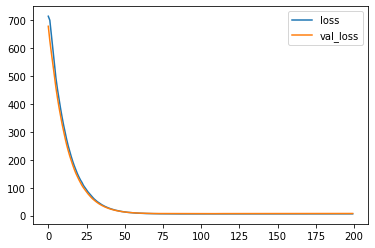

In [ ]:
feats= SMRfeat()
X_feat = feats.fit_transform(xtensor)
net= SMRDNN(verbose=1,epochs=200,l1_param=1e-3,l2_param=1e-3,validation_split=0.1)
predict_data = net.fit(X_feat , zpca)

In [ ]:
mdl = net.get_model()
w = get_weigths(mdl,3)

### Plots No MC

In [3]:
db = loaddb.GIGA()
channels_names = db.metadata['channel_names']
montage = mne.channels.read_montage(db.metadata['montage'])

Model = {}
#Model["model"] = mdl
Model["weigths"] = w
Model["Ch_names"] = channels_names
Model["montage"] = montage

# with open(Path_def+'models/'+folder_name+'wPLI_3f.p','wb') as handle:
#                 pickle.dump(Model,handle)

NameError: ignored

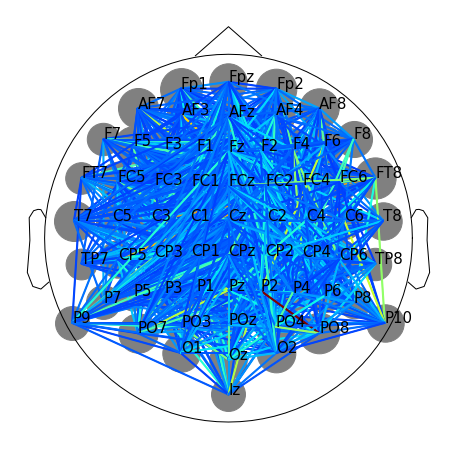

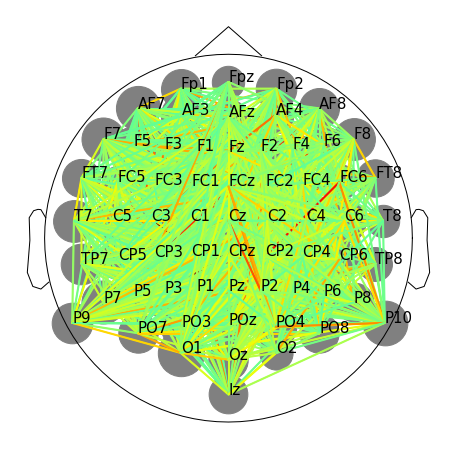

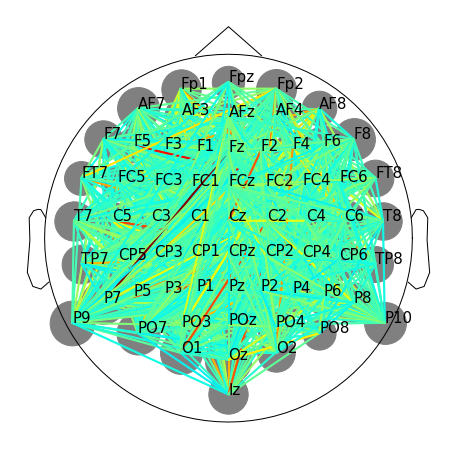

In [ ]:
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_topo_t')
plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_Cx_t')
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_All_t')

#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_topo_u')
plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_Cx_u')
#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_All_u')

#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_topo_B')
plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_Cx_B')
#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_All_B')

### Training MC

Epoch 1/200
2/2 [==============================] - 1s 234ms/step - loss: 718.8059 - val_loss: 682.5612
Epoch 2/200
2/2 [==============================] - 0s 84ms/step - loss: 699.1507 - val_loss: 633.0604
Epoch 3/200
2/2 [==============================] - 0s 77ms/step - loss: 649.8289 - val_loss: 586.8459
Epoch 4/200
2/2 [==============================] - 0s 79ms/step - loss: 599.7833 - val_loss: 545.7247
Epoch 5/200
2/2 [==============================] - 0s 77ms/step - loss: 548.3388 - val_loss: 511.7403
Epoch 6/200
2/2 [==============================] - 0s 80ms/step - loss: 510.4603 - val_loss: 475.6637
Epoch 7/200
2/2 [==============================] - 0s 77ms/step - loss: 473.2068 - val_loss: 441.0632
Epoch 8/200
2/2 [==============================] - 0s 213ms/step - loss: 439.0276 - val_loss: 408.6647
Epoch 9/200
2/2 [==============================] - 0s 78ms/step - loss: 407.3659 - val_loss: 378.5150
Epoch 10/200
2/2 [==============================] - 0s 75ms/step - loss: 377.188

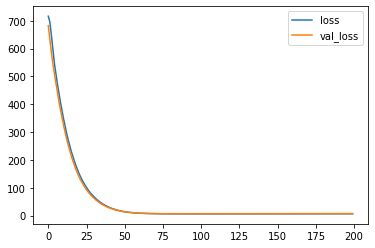

In [ ]:
feats= SMRfeat()
X_feat = feats.fit_transform(xtensor)
net= MCSMRDNN(verbose=1,epochs=200,l1_param=1e-3,l2_param=1e-3,validation_split=0.1,plot_hst=True,alpha_dropout=False)
predict_data = net.fit(X_feat , zpca)

In [ ]:
mdl = net.get_model()
w = get_weigths(mdl,3)

### Plots MC

In [ ]:
db = loaddb.GIGA()
channels_names = db.metadata['channel_names']
montage = mne.channels.read_montage(db.metadata['montage'])

Model = {}
#Model["model"] = mdl
Model["weigths"] = w
Model["Ch_names"] = channels_names
Model["montage"] = montage

with open(Path_def+'models/'+folder_name+'wPLI_3f_MC.p','wb') as handle:
                pickle.dump(Model,handle)

/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)


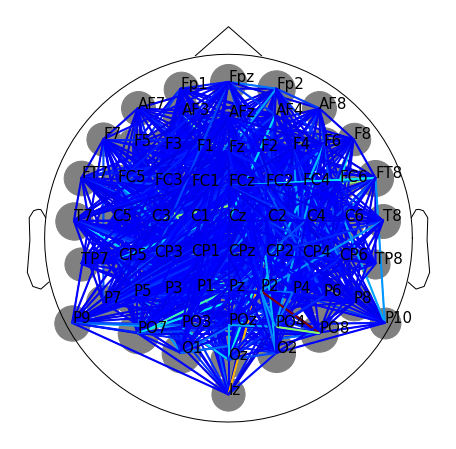

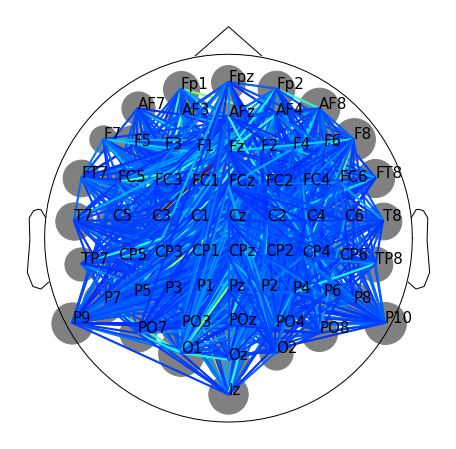

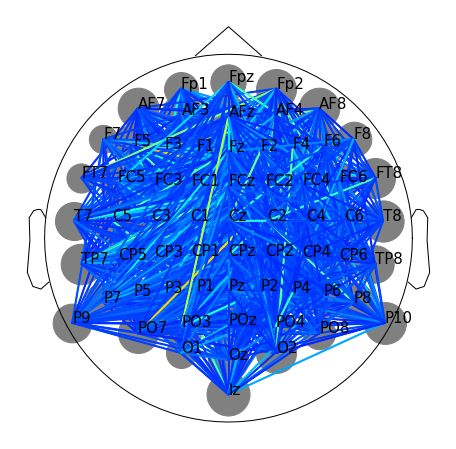

In [ ]:
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_topo_t')
plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_MC_Cx_t')
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_All_t')

#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_topo_u')
plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_MC_Cx_u')
#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_All_u')

#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_topo_B')
plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'wPLI_3f_MC_Cx_B')
#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/wPLI_3f_MC_All_B')

## PLV

### Load Data

In [ ]:
FILEID = "1dvuv8b5Ld6aKIVmJ5kOaMxHm3u5GCvch"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O connectividades_daniel.zip && rm -rf /tmp/cookies.txt
!dir
!unzip connectividades_daniel.zip

--2021-01-25 22:20:50--  https://docs.google.com/uc?export=download&confirm=&id=1dvuv8b5Ld6aKIVmJ5kOaMxHm3u5GCvch
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.138, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ve2fin69dar7mpa0p9utjple8i40gngg/21r7tlpf4p5ag1e58n7q6cp903mp0h3a/1611613200000/17600740636788319470/02182109817765677479Z/1dvuv8b5Ld6aKIVmJ5kOaMxHm3u5GCvch?e=download [following]
--2021-01-25 22:20:51--  https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ve2fin69dar7mpa0p9utjple8i40gngg/21r7tlpf4p5ag1e58n7q6cp903mp0h3a/1611613200000/17600740636788319470/02182109817765677479Z/1dvuv8b5Ld6aKIVmJ5kOaMxHm3u5GCvch?e=download
Resolving doc-0c-84-docs.googleusercontent.com (doc-0c-84-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to 

In [ ]:
data = loadmat('Data_resting_C3andC4.mat')

mea = data['means']
sc_ma = StandardScaler()
acc_m = mea.mean(axis=1)

ma_z = sc_ma.fit_transform(mea)
 
zpca = ma_z[:,3].reshape(-1,1)

In [ ]:
x= pickle.load( open( "connectividad_daniel_giga_3bandas.pickle", "rb" ) )
indx = loadmat('Means_giga_mayo.mat')['S1'].ravel()
xtensor = create_tensor_giga(x,indx)[:,:,:,0]

(50, 2016, 3, 1)


### Training No Mc

Epoch 1/200
2/2 [==============================] - 1s 244ms/step - loss: 721.3304 - val_loss: 683.0109
Epoch 2/200
2/2 [==============================] - 0s 81ms/step - loss: 702.5088 - val_loss: 642.0505
Epoch 3/200
2/2 [==============================] - 0s 87ms/step - loss: 654.5339 - val_loss: 587.5591
Epoch 4/200
2/2 [==============================] - 0s 78ms/step - loss: 595.5310 - val_loss: 542.0616
Epoch 5/200
2/2 [==============================] - 0s 80ms/step - loss: 539.7164 - val_loss: 495.3954
Epoch 6/200
2/2 [==============================] - 0s 79ms/step - loss: 495.0783 - val_loss: 457.6923
Epoch 7/200
2/2 [==============================] - 0s 78ms/step - loss: 457.4768 - val_loss: 421.8150
Epoch 8/200
2/2 [==============================] - 0s 77ms/step - loss: 419.9239 - val_loss: 387.8451
Epoch 9/200
2/2 [==============================] - 0s 79ms/step - loss: 384.5497 - val_loss: 356.4707
Epoch 10/200
2/2 [==============================] - 0s 76ms/step - loss: 352.4347

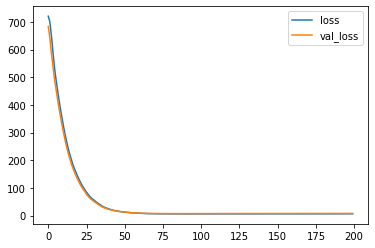

In [ ]:
feats= SMRfeat()
X_feat = feats.fit_transform(xtensor)
net= SMRDNN(verbose=1,epochs=200,l1_param=1e-3,l2_param=1e-3,validation_split=0.1)
predict_data = net.fit(X_feat , zpca)

In [ ]:
mdl = net.get_model()
w = get_weigths(mdl,3)

### Plos No Mc

In [ ]:
db = loaddb.GIGA()
channels_names = db.metadata['channel_names']
montage = mne.channels.read_montage(db.metadata['montage'])

Model["weigths"] = w
Model["Ch_names"] = channels_names
Model["montage"] = montage

with open(Path_def+'models/'+folder_name+'PLV_3f.p','wb') as handle:
                pickle.dump(Model,handle)

/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)


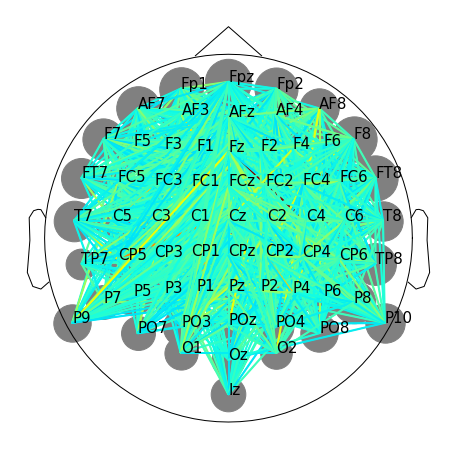

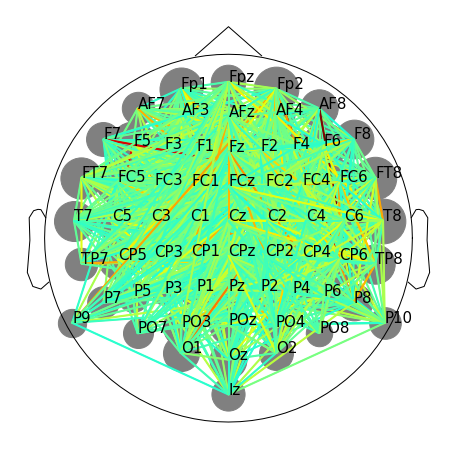

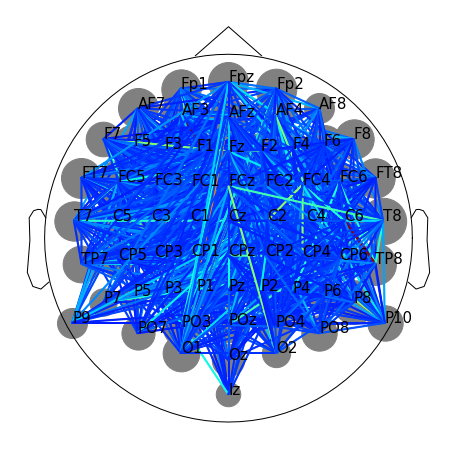

In [ ]:
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_topo_t')
plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_Cx_t')
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_All_t')

#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_topo_u')
plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_Cx_u')
#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_All_u')

#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_topo_B')
plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_Cx_B')
#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_All_B')

### Training MC

Epoch 1/200
2/2 [==============================] - 1s 414ms/step - loss: 723.2751 - val_loss: 684.6777
Epoch 2/200
2/2 [==============================] - 0s 82ms/step - loss: 703.0066 - val_loss: 644.6078
Epoch 3/200
2/2 [==============================] - 0s 76ms/step - loss: 655.7634 - val_loss: 598.4583
Epoch 4/200
2/2 [==============================] - 0s 78ms/step - loss: 602.6296 - val_loss: 556.4514
Epoch 5/200
2/2 [==============================] - 0s 80ms/step - loss: 556.8709 - val_loss: 516.2252
Epoch 6/200
2/2 [==============================] - 0s 76ms/step - loss: 513.0396 - val_loss: 482.4659
Epoch 7/200
2/2 [==============================] - 0s 77ms/step - loss: 476.6994 - val_loss: 445.1102
Epoch 8/200
2/2 [==============================] - 0s 77ms/step - loss: 440.8949 - val_loss: 411.2220
Epoch 9/200
2/2 [==============================] - 0s 77ms/step - loss: 409.2264 - val_loss: 379.1075
Epoch 10/200
2/2 [==============================] - 0s 77ms/step - loss: 376.7219

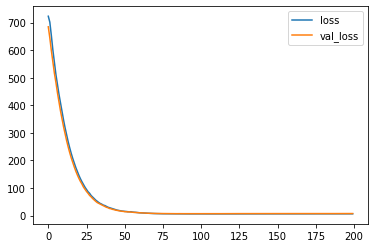

In [ ]:
feats= SMRfeat()
X_feat = feats.fit_transform(xtensor)
net= MCSMRDNN(verbose=1,epochs=200,l1_param=1e-3,l2_param=1e-3,validation_split=0.1,plot_hst=True,alpha_dropout=False)
predict_data = net.fit(X_feat , zpca)

In [ ]:
mdl = net.get_model()
w = get_weigths(mdl,3)

### Plots MC

In [ ]:
db = loaddb.GIGA()
channels_names = db.metadata['channel_names']
montage = mne.channels.read_montage(db.metadata['montage'])

Model["weigths"] = w
Model["Ch_names"] = channels_names
Model["montage"] = montage

with open(Path_def+'models/'+folder_name+'PLV_3f_MC.p','wb') as handle:
                pickle.dump(Model,handle)

/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)


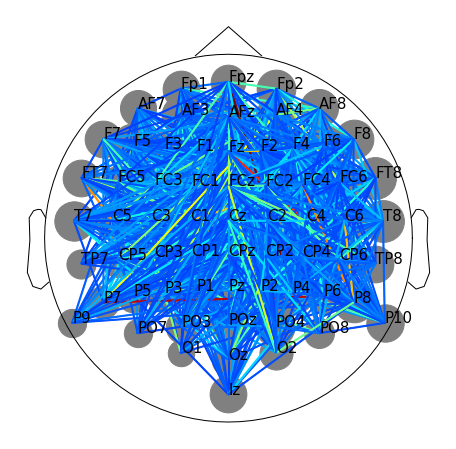

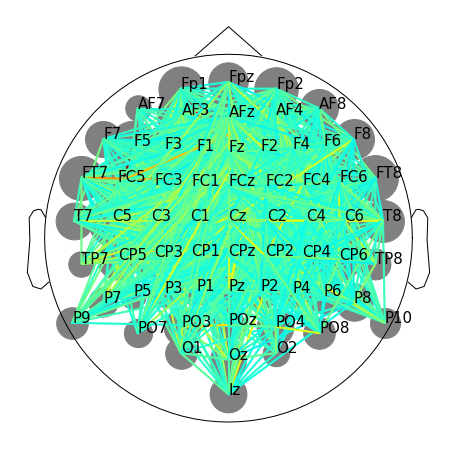

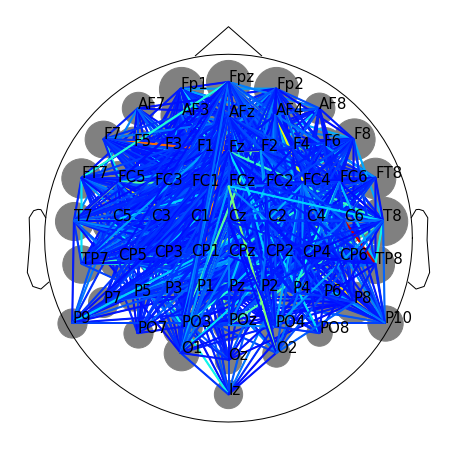

In [ ]:
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_topo_t')
plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_MC_Cx_t')
#plot_topomap_cx(w[0],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_All_t')

#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_topo_u')
plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_MC_Cx_u')
#plot_topomap_cx(w[1],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_All_u')

#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="topo",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_topo_B')
plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=tr,size=(8,8),mode="Cx",colormap=False,save=True,name=Path_def+'Topoplots/'+folder_name+'PLV_3f_MC_Cx_B')
#plot_topomap_cx(w[2],512, channels_names,montage,Ch=len(channels_names), thr=0.6,size=(8,8),mode="All",cmaps="Reds",colormap=False,save=True,name=Path_def+'Topoplots/PLV_3f_MC_All_B')